In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler,FunctionTransformer
import re
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator

In [3]:
# Load training dataset into pandas dataframe
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [4]:
# Calculate the number of missing values for each attribute
null_counts = df_train.isnull().sum()
print("The number of missing values for each attribute are:")
print(null_counts)


The number of missing values for each attribute are:
listing_id               0
title                    0
make                  1316
model                    0
description            680
manufactured             7
original_reg_date    24745
reg_date                 0
type_of_vehicle          0
category                 0
transmission             0
curb_weight            307
power                 2640
fuel_type            19121
engine_cap             596
no_of_owners            18
depreciation           507
coe                      0
road_tax              2632
dereg_value            220
mileage               5304
omv                     64
arf                    174
opc_scheme           24838
lifespan             22671
eco_category             0
features               843
accessories           3813
indicative_price     25000
price                    0
dtype: int64


In [5]:
# Generate descriptive statistics, including missing values count and percentage
descriptive_stats = df_train.describe(include='all').T
descriptive_stats['missing_values'] = null_counts
descriptive_stats['missing_percentage'] = (null_counts / len(df_train)) * 100

# Display descriptive statistics with missing values
print("Descriptive statistics with missing values:")
print(descriptive_stats)

Descriptive statistics with missing values:
                     count unique  \
listing_id         25000.0    NaN   
title                25000   7263   
make                 23684     95   
model                25000    799   
description          24320  19765   
manufactured       24993.0    NaN   
original_reg_date      255    219   
reg_date             25000   4705   
type_of_vehicle      25000     11   
category             25000    245   
transmission         25000      2   
curb_weight        24693.0    NaN   
power              22360.0    NaN   
fuel_type             5879      5   
engine_cap         24404.0    NaN   
no_of_owners       24982.0    NaN   
depreciation       24493.0    NaN   
coe                25000.0    NaN   
road_tax           22368.0    NaN   
dereg_value        24780.0    NaN   
mileage            19696.0    NaN   
omv                24936.0    NaN   
arf                24826.0    NaN   
opc_scheme             162      3   
lifespan              2329   14

## 1. Date Cleaning and Preprocessing

### (1) drop columns

'original_reg_date', 'opc_scheme','lifespan', 'indicative_price' are dropped due to too much missing values (missing_percentage>90%);
'listing_id' is dropped for no informative, 'eco_category' also dropped as there is only one unique value, 'description','accessories','features' are dropped due to free text with no clear structure.

In [6]:
# Define a custom function to drop specified columns
def drop_columns(df):
    return df.drop(columns=['listing_id', 'indicative_price', 'original_reg_date', 
                            'opc_scheme', 'lifespan', 'description', 'accessories', 
                            'features', 'eco_category'])


df_train = drop_columns(df_train)

# apply same process to test dataset
df_test = drop_columns(df_test)

In [7]:
num_records, num_attributes = df_train.shape

print("There are {} data points, each with {} attributes.". format(num_records, num_attributes))

There are 25000 data points, each with 21 attributes.


### (2) process 'category' feature

'category' now are contain different category value and connected with ',', we process it to extract information

In [8]:
# check the overview of all unique categories, we decide to extract the following features:
categories_exploded = df_train['category'].str.split(',').explode().str.strip()
category_counts = categories_exploded.value_counts()
print("\nCategory frequencies:\n", category_counts)


Category frequencies:
 category
parf car                   17007
premium ad car             12243
coe car                     5971
low mileage car             5737
hybrid cars                 2269
sgcarmart warranty cars     1818
direct owner sale           1742
almost new car              1005
rare & exotic                930
consignment car              637
electric cars                586
-                            516
imported used vehicle        214
vintage cars                 161
opc car                      159
sta evaluated car             46
Name: count, dtype: int64


Based on the general understanding about used cars, we will transform 'category' feature to the following features that we think are important and informative for used car price:
(1) dereg_type: Cars that have not renew the coe will get parf value when deregistration, which influence the used car price. we utitlze the existing category value 'parf car'(have not renew), 'coe car'(have renew), and also create a new value 'commercial car', as cars such trunk and mini bus are for commercial use, which will not have parf value whether they renew coe or not.

(2) engine_type: utilize category value 'electric cars' and 'hybric cars'.

(3) premium_ad_car

(4) opc_car

(5) low_mileage_car

(6) rare_exotic

In [9]:
# function to create dereg_type feature
def determine_dereg_type(category):
    if 'coe car' in category:
        return 'coe car'
    elif 'parf car' in category:
        return 'parf car'
    else:
        return 'commercial car'

# function to create engine_type feature
def determine_engine_type(category):
    if 'electric' in category:
        return 'electric'
    elif 'hybrid' in category:
        return 'hybrid'

# Apply custom functions to create new features
def add_category_features(df):
    df['dereg_type'] = df['category'].apply(determine_dereg_type)
    df['premium_ad_car'] = df['category'].apply(lambda x: 1 if 'premium ad car' in x else 0)
    df['engine_type'] = df['category'].apply(determine_engine_type)
    df['opc_car'] = df['category'].apply(lambda x: 1 if 'opc car' in x else 0)
    df['low_mileage_car'] = df['category'].apply(lambda x: 1 if 'low mileage car' in x else 0)
    df['rare_exotic'] = df['category'].apply(lambda x: 1 if 'rare & exotic' in x else 0)
    return df

df_train = add_category_features(df_train)

# apply same process to test dataset
df_test = add_category_features(df_test)

### (3) fill the missing value in 'make'


We can address the missing values in the `'make'` column by utilizing the information available in the `'title'` column. The `'title'` contains key details about the car, such as the make, model, and engine type/size. 

In [10]:
unique_makes = df_train['make'].unique() # Define a list of possible car makes
list_of_makes = list(unique_makes)
list_of_makes = [make for make in unique_makes if pd.notna(make)]

def fill_missing_make(df):
    def extract_make_from_title(title):
        for make in list_of_makes:
            if make in title.lower():
                return make
        return np.nan 
    df['make'] = df.apply(lambda row: row['make'] if pd.notna(row['make']) else extract_make_from_title(row['title']), axis=1)
    return df

# Apply the function to the 'title' column to fill missing values in 'make'
df_train = fill_missing_make(df_train)

missing_values_make = df_train['make'].isna().sum()
print(f"Missing values in 'make' column: {missing_values_make}")

# apply same process to test dataset
df_test = fill_missing_make(df_test)


Missing values in 'make' column: 0


### (4) 'manufacture' and 'reg_date'

In [11]:
def fill_manufactured_na(df):
    # Function to fill NA with mode, and leave as NA if mode doesn't exist
    def fill_na_with_mode(series):
        mode = series.mode()
        if not mode.empty:
            return series.fillna(mode[0])
        return series

    # Apply the function to each group ('make' and 'model'), keeping the original index intact
    df['manufactured'] = df.groupby(['make', 'model'])['manufactured'].transform(fill_na_with_mode)
    return df

df_train = fill_manufactured_na(df_train)

# apply same process to test dataset
df_test= fill_manufactured_na(df_test)

In [12]:
missing_values_manufactured = df_train['manufactured'].isna().sum()
print(f"Missing values in 'manufactured' column: {missing_values_manufactured}")

Missing values in 'manufactured' column: 0


We then create two features from 'manufactured' and 'reg_date'.

(1) car_age = current_date - manufactured

(2) COE_left month: we first retrive COE information in the title, if there is no relevant information we will calculate based on reg_date (We assume that all the COE will be valid for 10 years after the reg_date if no clear information is provided in the title)


In [13]:
current_date = datetime.now()

def process_date_features(df):
    # Convert 'reg_date' to datetime format
    df['reg_date'] = pd.to_datetime(df['reg_date'], format='%d-%b-%Y')
    
    # Calculate 'car_age' based on 'manufactured' column
    df['car_age'] = current_date.year - df['manufactured']
    
    # Calculate 'reg_years' as the number of years since registration
    df['reg_years'] = (current_date - df['reg_date']).dt.days // 365
    
    # Function to extract remaining COE months
    def extract_remaining_months(row):
        title = row['title']
        reg_date = row['reg_date']
        match = re.search(r'\(COE till (\d{2}/\d{4})\)', title)
        if match:
            coe_date_str = match.group(1)
            coe_date = datetime.strptime(coe_date_str, '%m/%Y')
        else:
            coe_date = reg_date + pd.DateOffset(years=10)
        
        remaining_months = (coe_date.year - current_date.year) * 12 + coe_date.month - current_date.month
        if remaining_months < 0:
            remaining_months = 0
        return remaining_months

    # Apply COE extraction function
    df['coe_left_month'] = df.apply(extract_remaining_months, axis=1)

    # Drop columns that are no longer needed
    df = df.drop(columns=['title', 'reg_date', 'reg_years','manufactured'])
    
    return df

In [14]:
df_train = process_date_features(df_train)

# apply same process to test dataset
df_test = process_date_features(df_test)

### (5) engine_cap & fuel type

For fuel_type, the similar information also store in 'engine_type' feature, we combine these two features. 

In [15]:
def fill_missing_engine_type(df):
    def fill_engine_type(fuel, engine):
        if pd.isnull(engine): 
            if fuel == 'electric':
                return 'electric'
            elif fuel in ['petrol-electric', 'diesel-electric']:
                return 'hybrid'
            elif fuel in ['diesel', 'petrol', np.nan]:
                return 'petrol/diesel'
        return engine 

    df['engine_type'] = df.apply(lambda row: fill_engine_type(row['fuel_type'], row['engine_type']), axis=1)
    
    df = df.drop(columns=(['fuel_type']))
    
    return df

df_train = fill_missing_engine_type(df_train)

# apply same process to test dataset
df_test = fill_missing_engine_type(df_test)

For engine_cap, we find that the missing values are all from electric cars, which have no engine, sowe fill the missing place with 0.

In [16]:
df_train[df_train['engine_cap'].isnull()]['engine_type'].unique()

array(['electric'], dtype=object)

In [17]:
def fill_engine_cap_for_electric(df):
    df.loc[(df['engine_type'] == 'electric') & (df['engine_cap'].isna()), 'engine_cap'] = 0
    return df

df_train = fill_engine_cap_for_electric(df_train)

# apply same process to test dataset
df_test = fill_engine_cap_for_electric(df_test)

In [18]:
missing_values_engine_cap = df_train['engine_cap'].isna().sum()
print(f"Missing values in 'manufactured' column: {missing_values_engine_cap}")

Missing values in 'manufactured' column: 0


### (6) Fill Missing Values in Other Key Columns


To address missing values in the columns `'curb_weight'`, `'power'`, we will use the mean value within groups of similar cars, categorized by `'make'` and `'model'`, or `'make'` and `'type_of_vehicle'`.

In [19]:
class FillMissingValuesWithGroups(TransformerMixin, BaseEstimator):
    def __init__(self, columns_to_fill, group_columns_1, group_columns_2):
        self.columns_to_fill = columns_to_fill
        self.group_columns_1 = group_columns_1
        self.group_columns_2 = group_columns_2
        self.global_means = {}
        self.group_means_1 = {}
        self.group_means_2 = {}

    def fit(self, X, y=None):
        # Calculate global means
        for column in self.columns_to_fill:
            self.global_means[column] = X[column].mean()

        # Calculate group means
        for column in self.columns_to_fill:
            self.group_means_1[column] = X.groupby(self.group_columns_1)[column].mean()
            self.group_means_2[column] = X.groupby(self.group_columns_2)[column].mean()
        
        return self
    
    def transform(self, X):
        X = X.copy()
        # Fill with group means
        for column in self.columns_to_fill:
            X[column] = X.groupby(self.group_columns_1)[column].transform(
                lambda x: x.fillna(self.group_means_1[column].get(tuple(x.name), float('nan')))
            )
            X[column] = X.groupby(self.group_columns_2)[column].transform(
                lambda x: x.fillna(self.group_means_2[column].get(tuple(x.name), float('nan')))
            )
        # Fill with global mean
        for column in self.columns_to_fill:
            X[column] = X[column].fillna(self.global_means[column])
        
        return X

columns_to_fill = ['curb_weight', 'power']
group_columns_1 = ['make', 'model']
group_columns_2 = ['make', 'type_of_vehicle']

filler_values = FillMissingValuesWithGroups(columns_to_fill, group_columns_1, group_columns_2)
filler_values.fit(df_train)

df_train = filler_values.transform(df_train)
df_test = filler_values.transform(df_test)

For the column `'no_of_owners'`, which is closely related to the car age, we will fill missing values using the mode for group of same car age.

In [20]:
class FillNoOfOwnersWithMode(TransformerMixin, BaseEstimator):
    def __init__(self, group_column):
        self.group_column = group_column
        self.modes = {}

    def fit(self, X, y=None):
        # Calculate group modes
        self.modes = X.groupby(self.group_column)['no_of_owners'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
        return self

    def transform(self, X):
        X = X.copy()
        # Fill with group mode
        X['no_of_owners'] = X.groupby(self.group_column)['no_of_owners'].transform(
            lambda x: x.fillna(self.modes.get(x.name, float('nan')))
        )
        return X

filler_no_of_owners = FillNoOfOwnersWithMode('car_age')
filler_no_of_owners.fit(df_train)

df_train = filler_no_of_owners.transform(df_train)
df_test = filler_no_of_owners.transform(df_test)



In [21]:
train_null_counts = df_train.isnull().sum()
print("The number of missing values for each attribute are:")
print(train_null_counts)

The number of missing values for each attribute are:
make                  0
model                 0
type_of_vehicle       0
category              0
transmission          0
curb_weight           0
power                 0
engine_cap            0
no_of_owners          0
depreciation        507
coe                   0
road_tax           2632
dereg_value         220
mileage            5304
omv                  64
arf                 174
price                 0
dereg_type            0
premium_ad_car        0
engine_type           0
opc_car               0
low_mileage_car       0
rare_exotic           0
car_age               0
coe_left_month        0
dtype: int64


In [22]:
numeric_columns = ['curb_weight','power','engine_cap','depreciation','coe','road_tax','dereg_value','omv','arf','coe_left_month','car_age','mileage']
df_numeric = df_train[numeric_columns]
correlation_matrix = df_numeric.corr()
correlation_matrix

curb_weight     power  engine_cap  depreciation       coe  \
curb_weight        1.000000  0.124322    0.672727      0.157345  0.047463   
power              0.124322  1.000000    0.450063      0.638506  0.312926   
engine_cap         0.672727  0.450063    1.000000      0.426726  0.023216   
depreciation       0.157345  0.638506    0.426726      1.000000  0.205189   
coe                0.047463  0.312926    0.023216      0.205189  1.000000   
road_tax           0.601688  0.822681    0.837934      0.511066  0.175221   
dereg_value        0.121021  0.598593    0.276487      0.706500  0.477311   
omv                0.250142  0.770203    0.599581      0.776646  0.235019   
arf                0.122187  0.754925    0.483589      0.823259  0.242024   
coe_left_month     0.074217  0.229327    0.042152      0.069714  0.387959   
car_age           -0.032278  0.009354    0.157291     -0.062571 -0.313816   
mileage           -0.009683 -0.222576    0.026232     -0.251363 -0.341928   

                road_tax  dereg_value       omv       arf  coe_left_month  \
curb_weight     0.601688     0.121021  0.250142  0.122187        0.074217   
power           0.822681     0.598593  0.770203  0.754925        0.229327   
engine_cap      0.837934     0.276487  0.599581  0.483589        0.042152   
depreciation    0.511066     0.706500  0.776646  0.823259        0.069714   
coe             0.175221     0.477311  0.235019  0.242024        0.387959   
road_tax        1.000000     0.385072  0.776447  0.669683        0.201243   
dereg_value     0.385072     1.000000  0.725511  0.837359        0.408558   
omv             0.776447     0.725511  1.000000  0.946252        0.206252   
arf             0.669683     0.837359  0.946252  1.000000        0.171619   
coe_left_month  0.201243     0.408558  0.206252  0.171619        1.000000   
car_age         0.213256    -0.322802  0.001942 -0.026948       -0.273756   
mileage        -0.051804    -0.421335 -0.205686 -0.228203       -0.489547   

                 car_age   mileage  
curb_weight    -0.032278 -0.009683  
power           0.009354 -0.222576  
engine_cap      0.157291  0.026232  
depreciation   -0.062571 -0.251363  
coe            -0.313816 -0.341928  
road_tax        0.213256 -0.051804  
dereg_value    -0.322802 -0.421335  
omv             0.001942 -0.205686  
arf            -0.026948 -0.228203  
coe_left_month -0.273756 -0.489547  
car_age         1.000000  0.589915  
mileage         0.589915  1.000000

Based on the correlation matrix, we observe a very high correlations between `'arf'` and `'omv'`, so we drop `'arf'`.

`'arf'` also has a high correlation with `'dereg_value'` and `'depreciation'`, we use `'arf'` to impute missing values in the following three features:
`'omv'`, `'depreciation'`, `'dereg_value'`

For `'mileage'`, which has relatively large missing values and the 'low_mileage' feature contain information about mileage, so we drop it.

For `'road_tax'`, it also has relatively large missing values and have high correlation with 'engine_cap', so we also drop it.

In [23]:
class ImputeAndDropArf(TransformerMixin, BaseEstimator):
    def __init__(self, features_to_predict):
        self.features_to_predict = features_to_predict
        self.models = {}
        self.global_means = {}

    def fit(self, X, y=None):
        X = X.copy()

        for feature in self.features_to_predict:
            # Get data with non-null 'arf' and feature
            train_not_null = X[X[feature].notnull() & X['arf'].notnull()]

            # Train regression model if sufficient data exists
            if not train_not_null.empty:
                reg = LinearRegression()
                reg.fit(train_not_null[['arf']], train_not_null[feature])
                self.models[feature] = reg

            # Store global mean for fallback
            self.global_means[feature] = X[feature].mean()

        return self

    def transform(self, X):
        X = X.copy()

        for feature in self.features_to_predict:
            if feature in self.models:
                # Fill missing values using the trained model
                null_data = X[X[feature].isnull() & X['arf'].notnull()]
                if not null_data.empty:
                    X.loc[null_data.index, feature] = self.models[feature].predict(null_data[['arf']])

            # Fallback: Fill remaining missing values with global mean
            X[feature] = X[feature].fillna(self.global_means[feature])

        
        X = X.drop(columns=['arf','mileage','road_tax'], errors='ignore')

        return X

features_to_predict = ['omv', 'depreciation', 'dereg_value']
imputer = ImputeAndDropArf(features_to_predict)


imputer.fit(df_train)

df_train = imputer.transform(df_train)
df_test = imputer.transform(df_test)

In [24]:
train_null_counts = df_train.isnull().sum()
print("The number of missing value for each column are:")
print(train_null_counts)

The number of missing value for each column are:
make               0
model              0
type_of_vehicle    0
category           0
transmission       0
curb_weight        0
power              0
engine_cap         0
no_of_owners       0
depreciation       0
coe                0
dereg_value        0
omv                0
price              0
dereg_type         0
premium_ad_car     0
engine_type        0
opc_car            0
low_mileage_car    0
rare_exotic        0
car_age            0
coe_left_month     0
dtype: int64


Now we finish dealing with all missing values.

In [25]:
test_null_counts = df_test.isnull().sum()
print("The number of missing value for each column are:")
print(test_null_counts)

The number of missing value for each column are:
make               0
model              0
type_of_vehicle    0
category           0
transmission       0
curb_weight        0
power              0
engine_cap         0
no_of_owners       0
depreciation       0
coe                0
dereg_value        0
omv                0
dereg_type         0
premium_ad_car     0
engine_type        0
opc_car            0
low_mileage_car    0
rare_exotic        0
car_age            0
coe_left_month     0
dtype: int64


We create to new features 'total_depreciation' and 'coe_left_value'

In [26]:
df_train['depreciation_total'] = df_train['depreciation'] * df_train['coe_left_month']
df_train['coe_adjusted'] = (df_train['coe'] * df_train['coe_left_month']) / 120

df_test['depreciation_total'] = df_test['depreciation'] * df_test['coe_left_month']
df_test['coe_adjusted'] = (df_test['coe'] * df_test['coe_left_month']) / 120

## Distribution of variables

### 1. Distribution of numeric variables

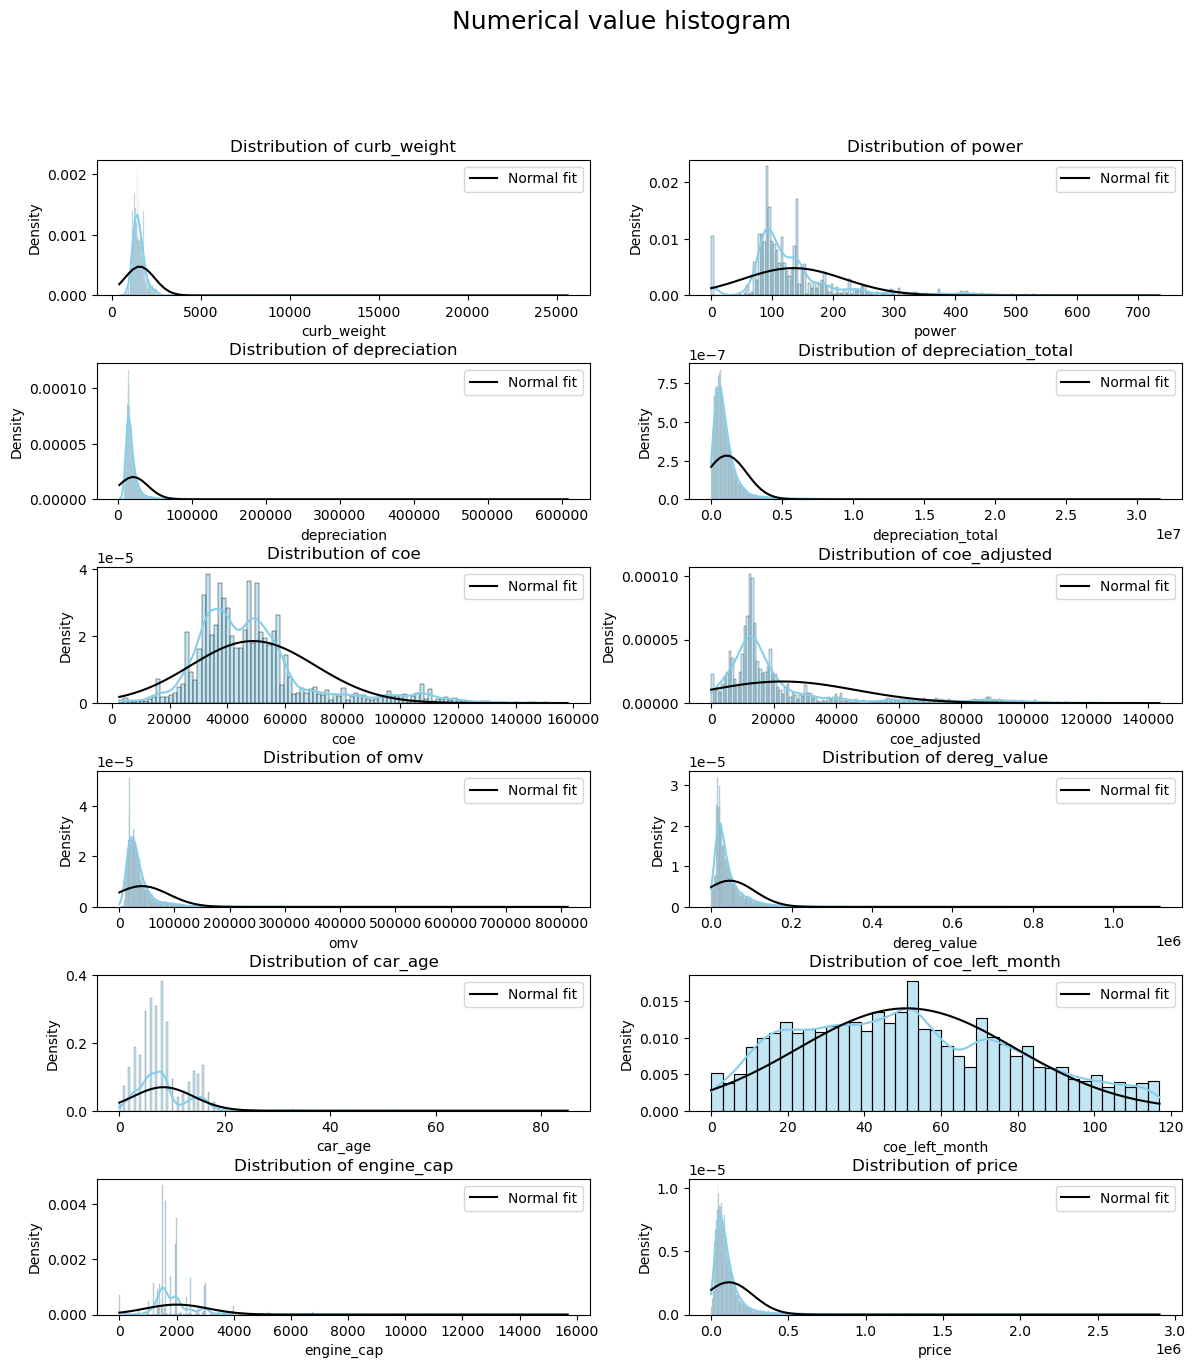

In [27]:
num_value_col = ['curb_weight','power','depreciation','depreciation_total','coe','coe_adjusted','omv','dereg_value','car_age','coe_left_month','engine_cap','price']
fig, axes = plt.subplots(6,2, figsize=(14, 15))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Numerical value histogram',fontsize=18)

i=0
n=0
for x in num_value_col:
    # Plot histogram
    sns.histplot(df_train[x], kde=True, stat="density", ax=axes[i, n], color='skyblue')
    
    # Fit normal distribution and plot the fitted curve
    mean, std = stats.norm.fit(df_train[x].dropna())  # Fit normal distribution
    x_vals = np.linspace(df_train[x].min(), df_train[x].max(), 100)
    pdf_vals = stats.norm.pdf(x_vals, mean, std)
    axes[i, n].plot(x_vals, pdf_vals, color='black' ,label='Normal fit')  # Plot the fitted curve
    axes[i, n].set_title(f'Distribution of {x}')
    axes[i, n].legend()

    if n < 1:
        n += 1
    else:
        n = 0
        i += 1

plt.show()

Based on the distribution of target variable 'price', we decide to change it to log_price.

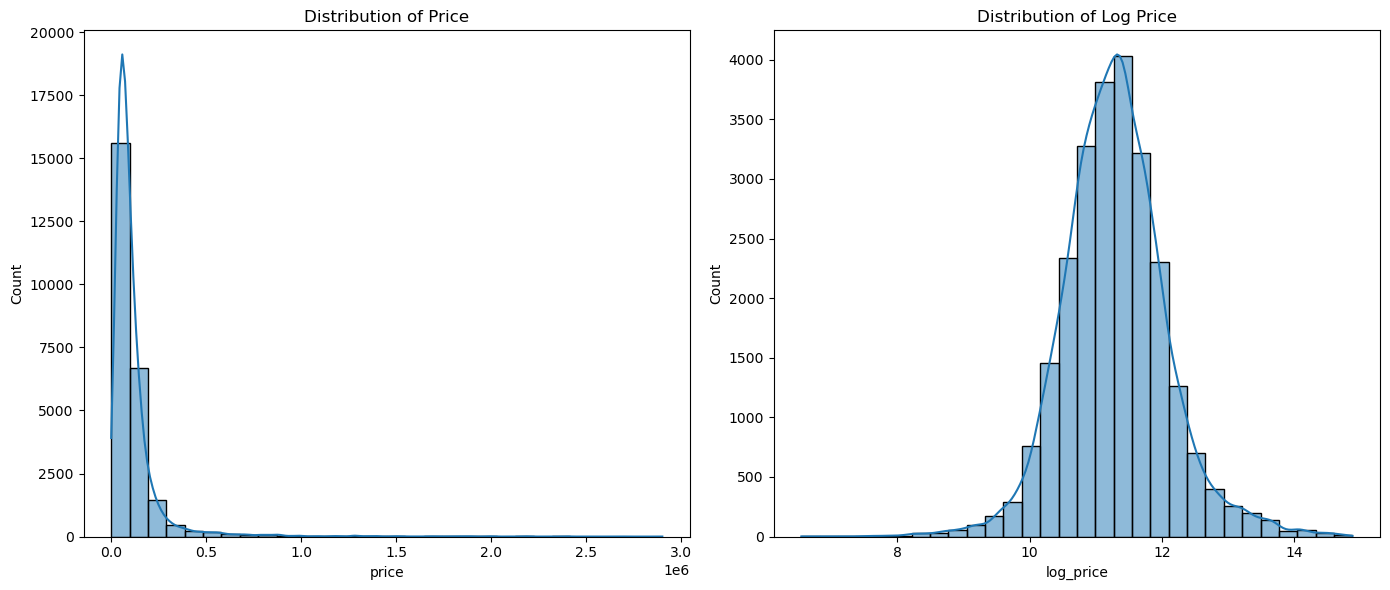

In [28]:
import numpy as np


df_train['log_price'] = np.log(df_train['price'])
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_train['price'], bins=30, kde=True)
plt.title('Distribution of Price')

plt.subplot(1, 2, 2)
sns.histplot(df_train['log_price'], bins=30, kde=True)
plt.title('Distribution of Log Price')

plt.tight_layout()
plt.show()

In [29]:
num_value_col.append('log_price')
num_value_col.remove('price')

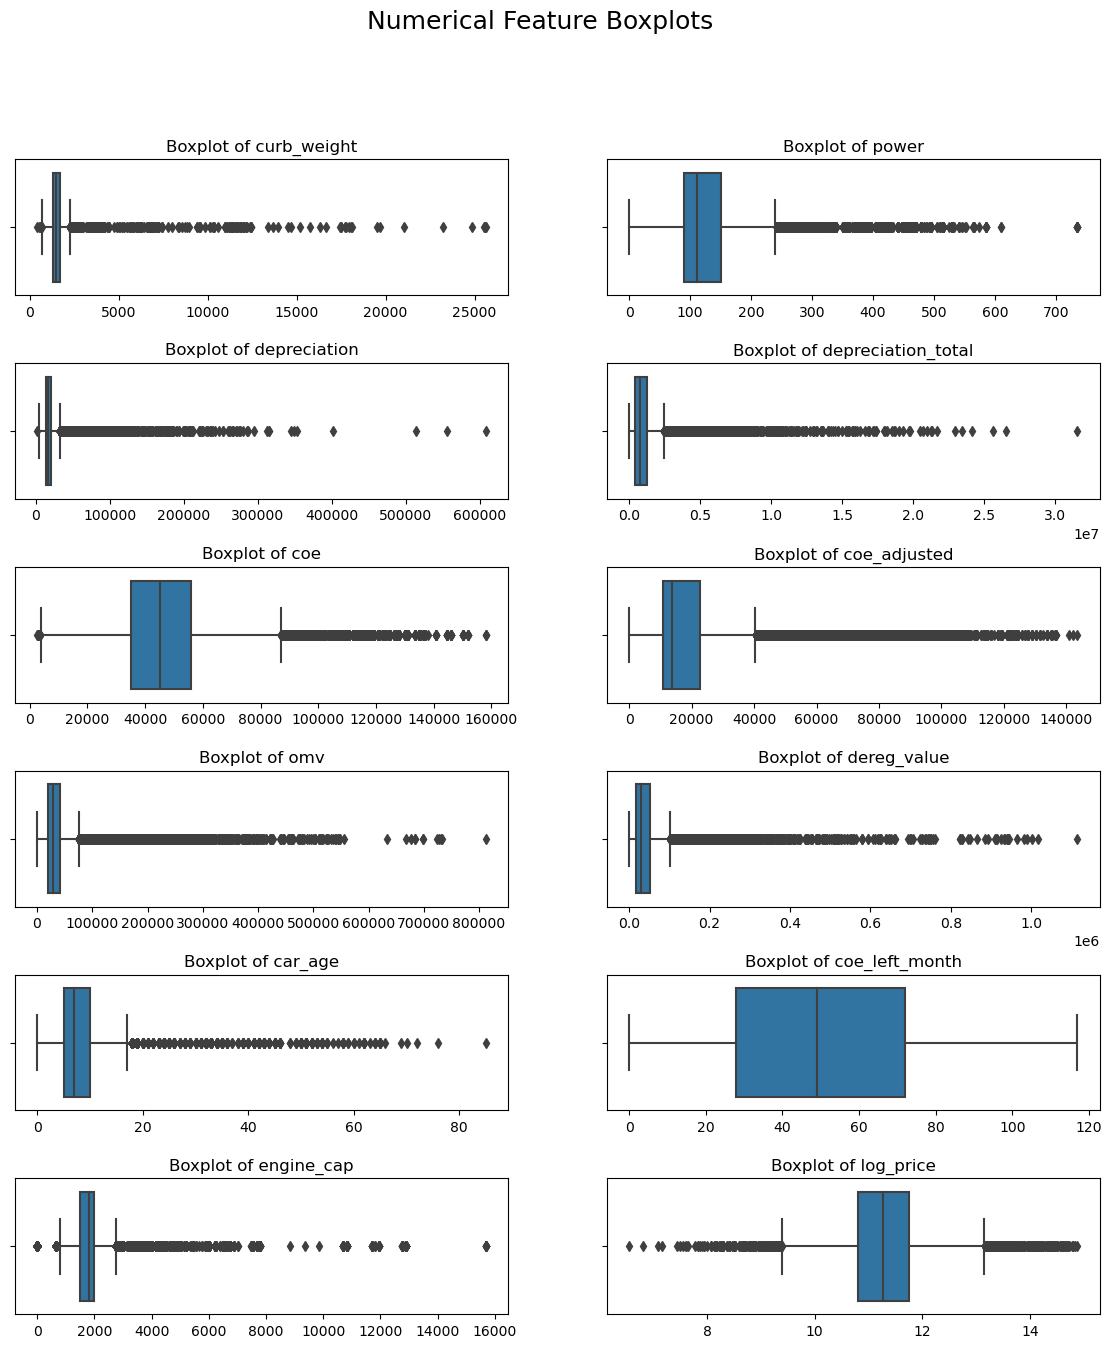

In [30]:
fig, axes = plt.subplots(6, 2, figsize=(14, 15))  # Adjust based on the number of features
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Numerical Feature Boxplots', fontsize=18)

i = 0
n = 0

for x in num_value_col:
    sns.boxplot(x=x, data=df_train, ax=axes[i, n])  # Plot horizontal boxplot
    axes[i, n].set_title(f'Boxplot of {x}', fontsize=12)  # Set title for each subplot
    axes[i, n].set_xlabel('')  # Optionally remove the x-axis label

    if n < 1:
        n += 1
    else:
        n = 0
        i += 1

plt.show()

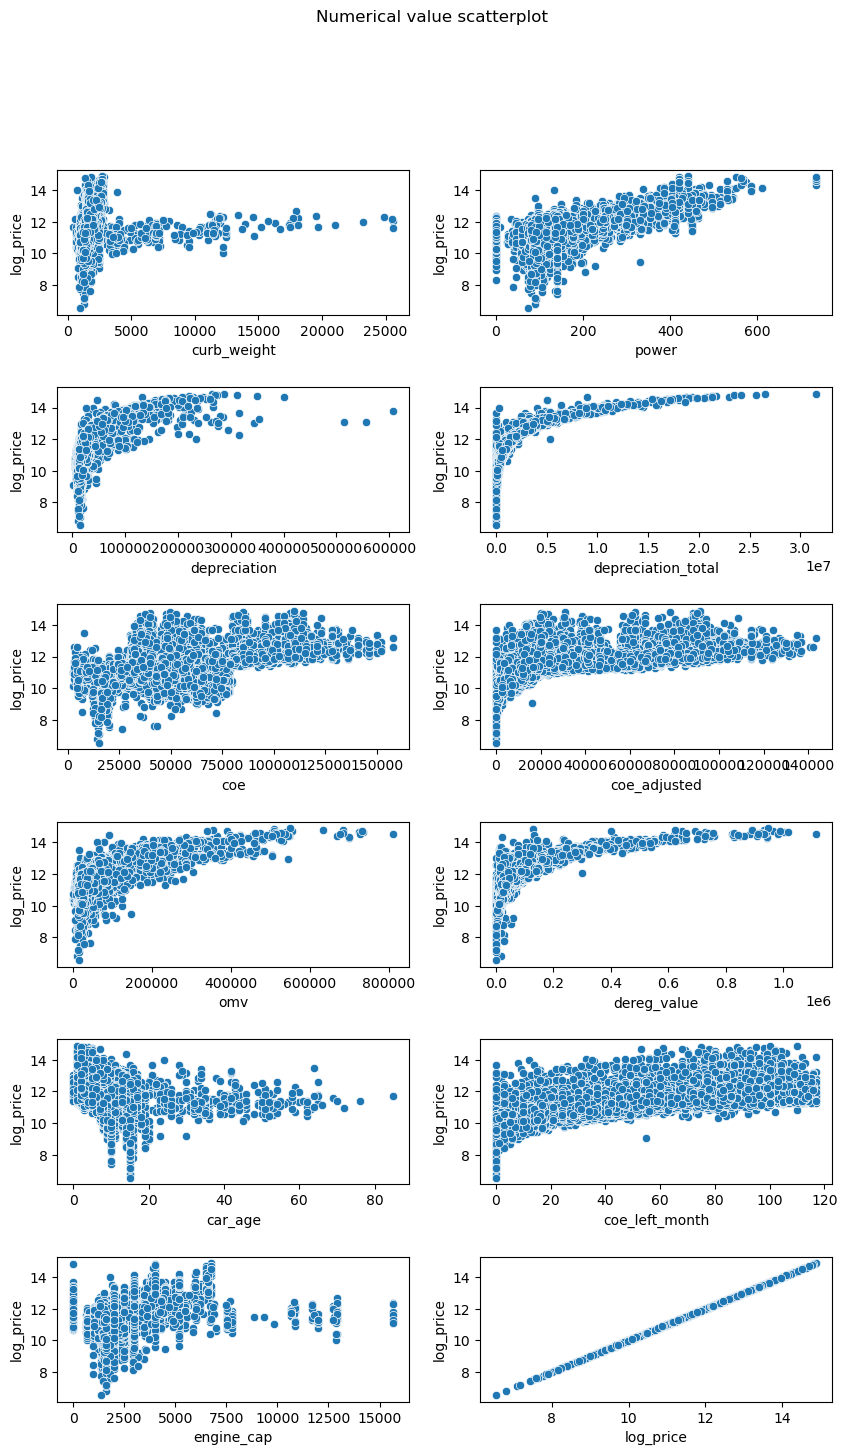

In [31]:
fig, axes = plt.subplots(6, 2, figsize=(10, 16))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Numerical value scatterplot')

i=0
n=0

for x,y in enumerate(num_value_col):
    p = sns.scatterplot(data=df_train,x=num_value_col[x],y='log_price',ax=axes[i,n])
    p.set(xlabel = num_value_col[x])

    if n < 1:
        n+=1
    else:
        n=0
        i+=1
plt.show()

### Distribution of categorical variables


In [32]:
make_name = df_train['make'].unique()
make_name = sorted(list(make_name))

model_name = df_train['model'].unique()
model_name = sorted(list(model_name))

print(f'We have {len(make_name)} unique make names, and {len(model_name)} unique model names')

We have 95 unique make names, and 799 unique model names


In [33]:
df_train['type_of_vehicle'].unique()

array(['suv', 'luxury sedan', 'mpv', 'mid-sized sedan', 'sports car',
       'truck', 'hatchback', 'stationwagon', 'bus/mini bus', 'van',
       'others'], dtype=object)

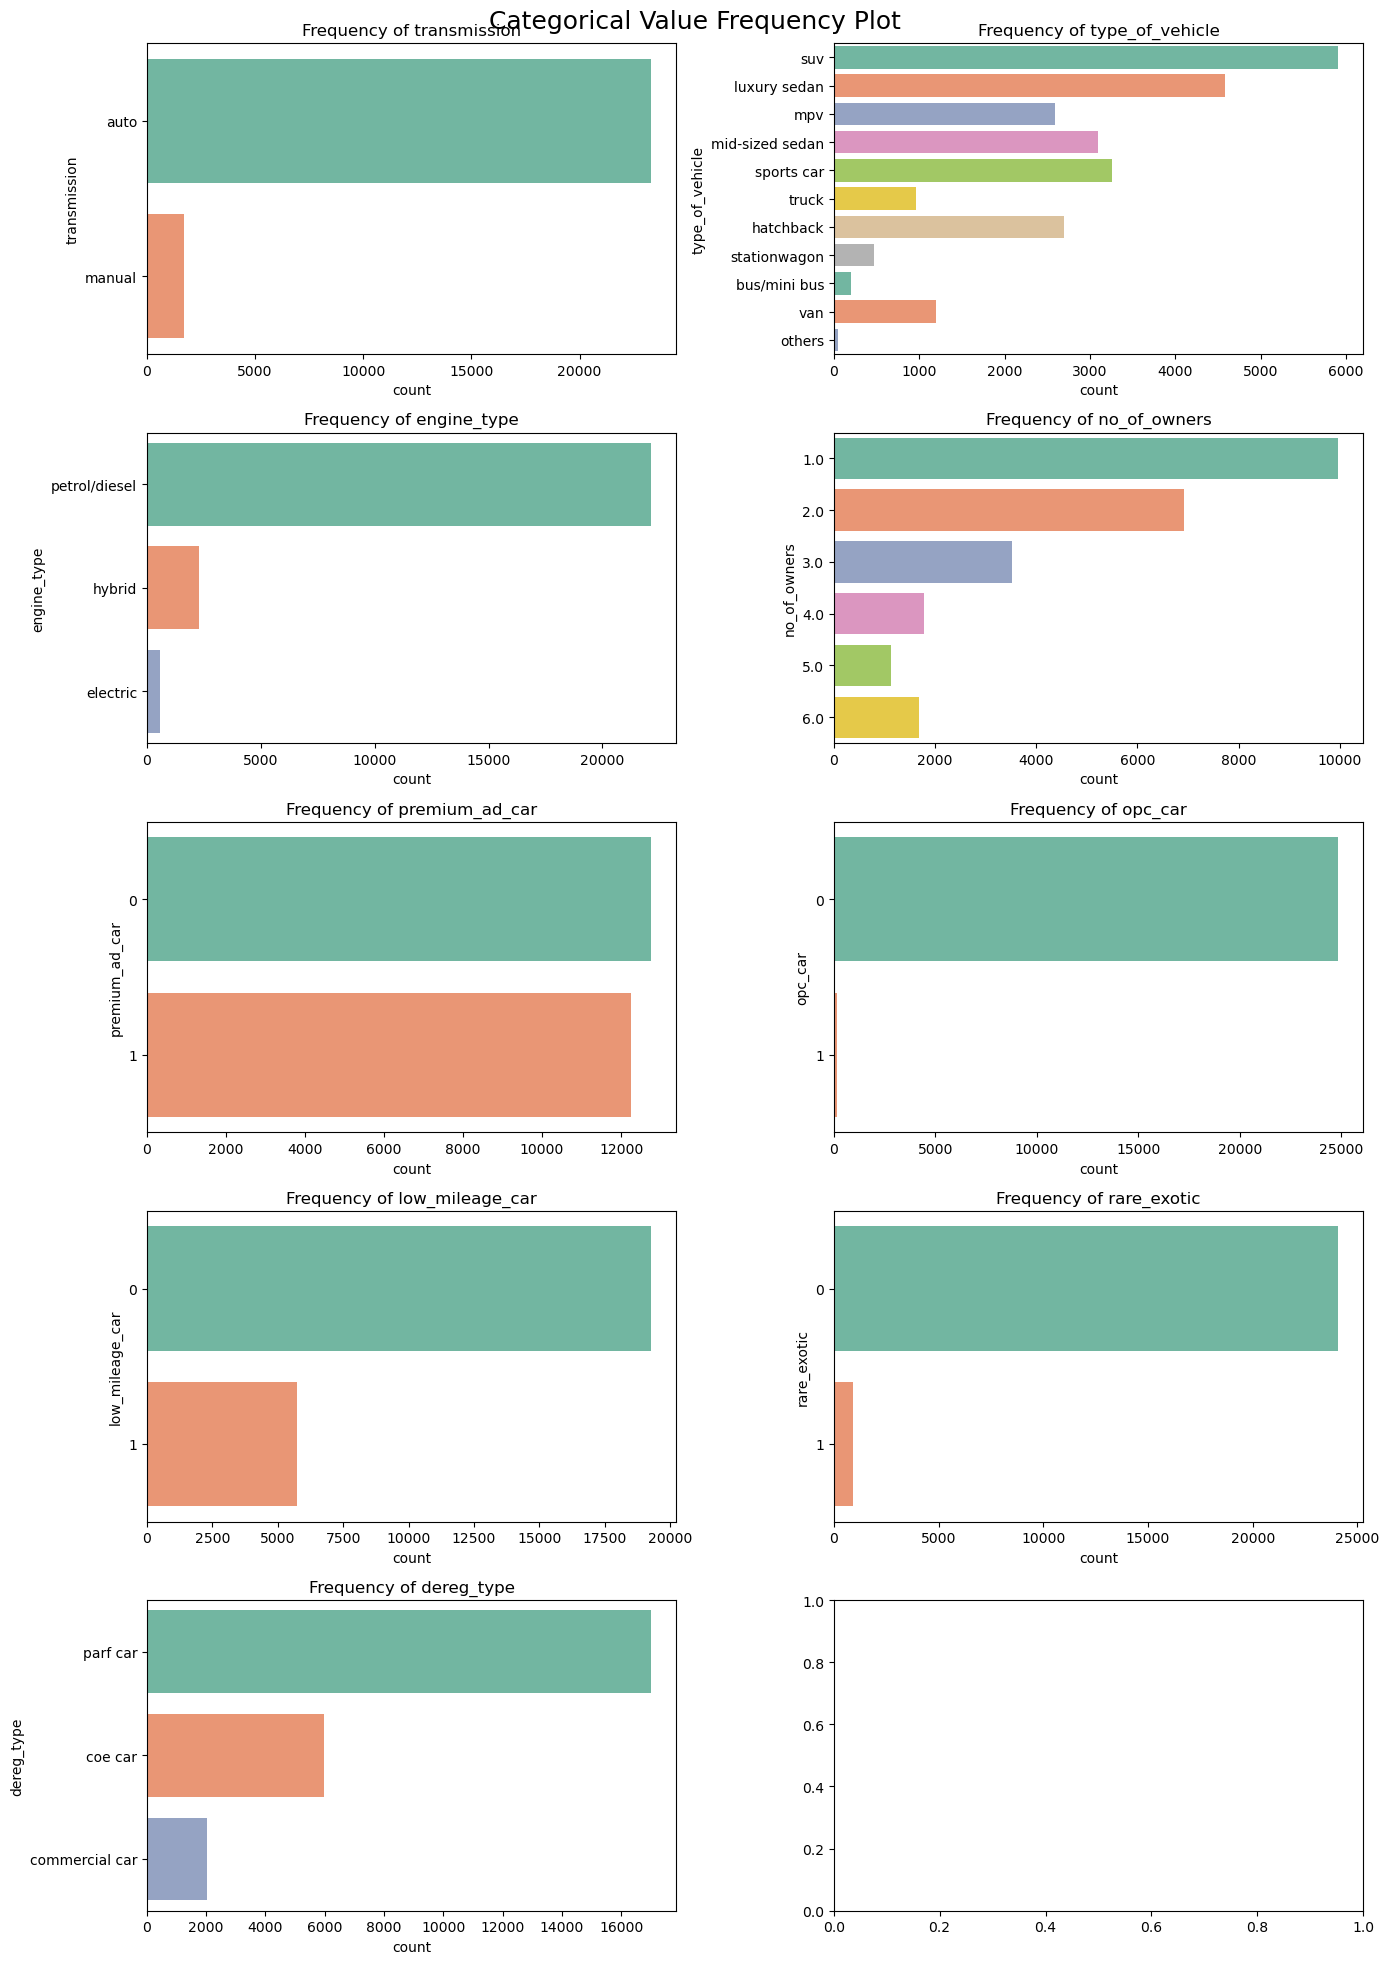

In [34]:
cat_value_col = ['transmission','type_of_vehicle','engine_type','no_of_owners','premium_ad_car','opc_car','low_mileage_car','rare_exotic','dereg_type']

fig, axes = plt.subplots(len(cat_value_col)//2 + len(cat_value_col)%2, 2, figsize=(14, 20))  
fig.subplots_adjust(hspace=0.7)
fig.suptitle('Categorical Value Frequency Plot', fontsize=18)

i = 0
n = 0

for x in cat_value_col:
    sns.countplot(y=x, data=df_train, ax=axes[i, n], palette='Set2')  
    axes[i, n].set_title(f'Frequency of {x}')
    
    if n < 1:
        n += 1
    else:
        n = 0
        i += 1

plt.tight_layout()
plt.show()


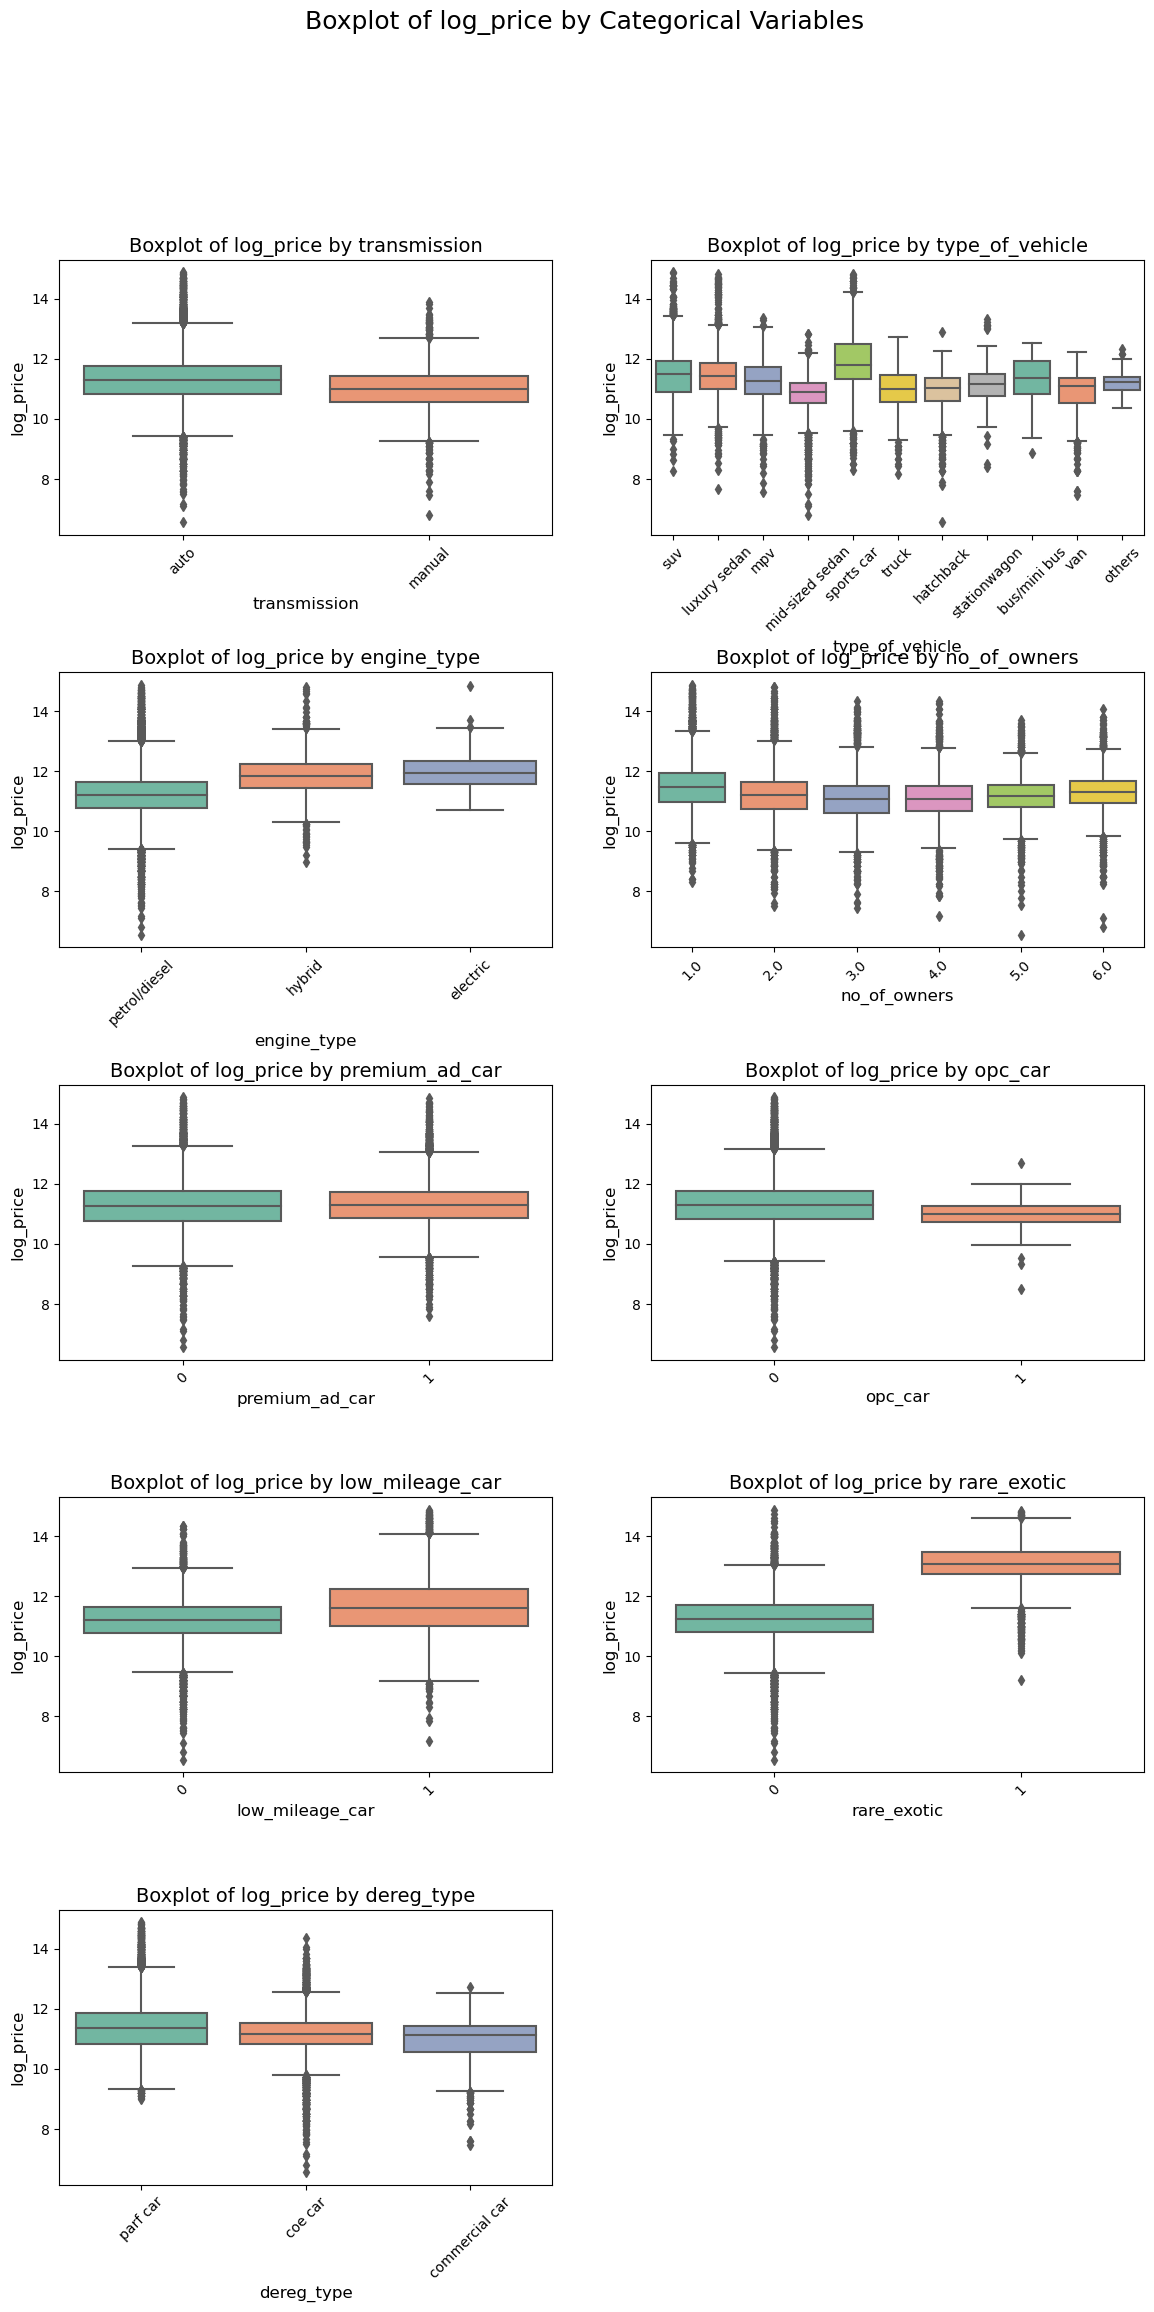

In [35]:
n_rows = (len(cat_value_col) + 1) // 2 
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 5 * n_rows))  
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Boxplot of log_price by Categorical Variables', fontsize=18)


for i, x in enumerate(cat_value_col):
    ax = axes[i // 2, i % 2]  
    sns.boxplot(x=x, y='log_price', data=df_train, ax=ax, palette='Set2')
    ax.set_title(f'Boxplot of log_price by {x}', fontsize=14)
    ax.set_xlabel(x, fontsize=12)
    ax.set_ylabel('log_price', fontsize=12)
    ax.tick_params(axis='x', rotation=45) 

if len(cat_value_col) % 2 != 0:
    axes[-1, 1].axis('off') 

plt.show()


## Feature Encoding

In [36]:
import category_encoders as ce
encoder = ce.TargetEncoder(cols=['make', 'model'])
# Apply target encoding to 'make' and 'model' columns using 'price' as the target
df_encoded_make_model = encoder.fit_transform(df_train[['make', 'model']], df_train['log_price'])
df_encoded_make_model.columns = ['make_encode', 'model_encode']
# Display the target-encoded DataFrame
df_encoded_make_model.head()

make_encode  model_encode
0    11.916217     12.021958
1    11.608552     11.099386
2    11.034513     10.801187
3    11.185517     10.719189
4    11.427196     11.102980

In [37]:
df_train = pd.concat([df_train, df_encoded_make_model], axis=1)
df_train.head()

make    model  type_of_vehicle  \
0     land rover    range              suv   
1  mercedes-benz     c200     luxury sedan   
2          honda  odyssey              mpv   
3         toyota    altis  mid-sized sedan   
4          lexus       gs     luxury sedan   

                                   category transmission  curb_weight  power  \
0                                  parf car         auto       1884.0  280.0   
1                  parf car, premium ad car         auto       1465.0  135.0   
2  coe car, premium ad car, low mileage car         auto       1648.0  118.0   
3                   coe car, premium ad car         auto       1195.0   80.0   
4                   coe car, premium ad car         auto       1660.0  183.0   

   engine_cap  no_of_owners  depreciation  ...  opc_car  low_mileage_car  \
0      2995.0           2.0       34270.0  ...        0                0   
1      1991.0           2.0       21170.0  ...        0                0   
2      2354.0           3.0       12520.0  ...        0                1   
3      1598.0           3.0       10140.0  ...        0                0   
4      2995.0           6.0       13690.0  ...        0                0   

   rare_exotic  car_age coe_left_month  depreciation_total  coe_adjusted  \
0            0      6.0             40           1370800.0  16003.666667   
1            0      7.0             37            783290.0  14492.283333   
2            0     17.0             34            425680.0  14267.250000   
3            0     16.0             49            496860.0  11258.158333   
4            0     18.0             19            260110.0   7675.841667   

   log_price  make_encode  model_encode  
0  12.174520    11.916217     12.021958  
1  11.480402    11.608552     11.099386  
2  10.591622    11.034513     10.801187  
3  10.709963    11.185517     10.719189  
4  10.158130    11.427196     11.102980  

[5 rows x 27 columns]

In [38]:
df_encoded_make_model_test = encoder.transform(df_test[['make', 'model']])

df_encoded_make_model_test.columns = ['make_encode', 'model_encode']
df_test = pd.concat([df_test, df_encoded_make_model_test], axis=1)

In [39]:
# Perform one-hot encoding on the 'transmission' column
df_train = pd.get_dummies(df_train, columns=['transmission'], drop_first=True, dtype=int)
df_test = pd.get_dummies(df_test, columns=['transmission'], drop_first=True, dtype=int)

df_train = pd.get_dummies(df_train, columns=['engine_type'], drop_first=True, dtype=int)
df_test = pd.get_dummies(df_test, columns=['engine_type'], drop_first=True, dtype=int)

df_train = pd.get_dummies(df_train, columns=['dereg_type'], drop_first=True, dtype=int)
df_test = pd.get_dummies(df_test, columns=['dereg_type'], drop_first=True, dtype=int)

In [40]:
# Apply target encoding to 'type_of_vehicle' using 'price' as the target
encoder = ce.TargetEncoder(cols=['type_of_vehicle'])
df_encoded_type = encoder.fit_transform(df_train[['type_of_vehicle']], df_train['log_price'])
df_encoded_type.columns = ['vehicle_type_encode']
df_encoded_type.head()

vehicle_type_encode
0            11.437522
1            11.429823
2            11.258383
3            10.794520
4            11.429823

In [41]:
# Concatenate the encoded 'type_of_vehicle' column back to the original DataFrame, dropping the original column
df_train = pd.concat([df_train, df_encoded_type], axis=1)
df_train.head()

make    model  type_of_vehicle  \
0     land rover    range              suv   
1  mercedes-benz     c200     luxury sedan   
2          honda  odyssey              mpv   
3         toyota    altis  mid-sized sedan   
4          lexus       gs     luxury sedan   

                                   category  curb_weight  power  engine_cap  \
0                                  parf car       1884.0  280.0      2995.0   
1                  parf car, premium ad car       1465.0  135.0      1991.0   
2  coe car, premium ad car, low mileage car       1648.0  118.0      2354.0   
3                   coe car, premium ad car       1195.0   80.0      1598.0   
4                   coe car, premium ad car       1660.0  183.0      2995.0   

   no_of_owners  depreciation    coe  ...  coe_adjusted  log_price  \
0           2.0       34270.0  48011  ...  16003.666667  12.174520   
1           2.0       21170.0  47002  ...  14492.283333  11.480402   
2           3.0       12520.0  50355  ...  14267.250000  10.591622   
3           3.0       10140.0  27571  ...  11258.158333  10.709963   
4           6.0       13690.0  48479  ...   7675.841667  10.158130   

   make_encode  model_encode  transmission_manual  engine_type_hybrid  \
0    11.916217     12.021958                    0                   0   
1    11.608552     11.099386                    0                   0   
2    11.034513     10.801187                    0                   0   
3    11.185517     10.719189                    0                   0   
4    11.427196     11.102980                    0                   0   

   engine_type_petrol/diesel  dereg_type_commercial car  dereg_type_parf car  \
0                          1                          0                    1   
1                          1                          0                    1   
2                          1                          0                    0   
3                          1                          0                    0   
4                          1                          0                    0   

   vehicle_type_encode  
0            11.437522  
1            11.429823  
2            11.258383  
3            10.794520  
4            11.429823  

[5 rows x 30 columns]

In [42]:
df_encoded_type_test = encoder.transform(df_test[['type_of_vehicle']])

df_encoded_type_test.columns = ['vehicle_type_encode']
df_test = pd.concat([df_test, df_encoded_type_test], axis=1)

In [43]:
df_train.columns

Index(['make', 'model', 'type_of_vehicle', 'category', 'curb_weight', 'power',
       'engine_cap', 'no_of_owners', 'depreciation', 'coe', 'dereg_value',
       'omv', 'price', 'premium_ad_car', 'opc_car', 'low_mileage_car',
       'rare_exotic', 'car_age', 'coe_left_month', 'depreciation_total',
       'coe_adjusted', 'log_price', 'make_encode', 'model_encode',
       'transmission_manual', 'engine_type_hybrid',
       'engine_type_petrol/diesel', 'dereg_type_commercial car',
       'dereg_type_parf car', 'vehicle_type_encode'],
      dtype='object')

In [44]:
df_columns = ['curb_weight', 'power',
       'engine_cap', 'depreciation', 'coe', 'dereg_value',
       'omv', 'car_age', 'coe_left_month', 'depreciation_total',
       'coe_adjusted']

scaler = StandardScaler()

df_train.loc[:,df_columns] = scaler.fit_transform(df_train[df_columns]).astype(float)
df_train.head()

make    model  type_of_vehicle  \
0     land rover    range              suv   
1  mercedes-benz     c200     luxury sedan   
2          honda  odyssey              mpv   
3         toyota    altis  mid-sized sedan   
4          lexus       gs     luxury sedan   

                                   category  curb_weight     power  \
0                                  parf car     0.366229  1.746829   
1                  parf car, premium ad car    -0.136376 -0.002507   
2  coe car, premium ad car, low mileage car     0.083139 -0.207601   
3                   coe car, premium ad car    -0.460251 -0.666048   
4                   coe car, premium ad car     0.097533  0.576584   

   engine_cap  no_of_owners  depreciation       coe  ...  coe_adjusted  \
0    0.890509           2.0      0.693499 -0.042842  ...     -0.289888   
1   -0.017377           2.0      0.031968 -0.089589  ...     -0.354285   
2    0.310873           3.0     -0.404845  0.065755  ...     -0.363873   
3   -0.372754           3.0     -0.525031 -0.989825  ...     -0.492083   
4    0.890509           6.0     -0.345761 -0.021160  ...     -0.644717   

   log_price  make_encode  model_encode  transmission_manual  \
0  12.174520    11.916217     12.021958                    0   
1  11.480402    11.608552     11.099386                    0   
2  10.591622    11.034513     10.801187                    0   
3  10.709963    11.185517     10.719189                    0   
4  10.158130    11.427196     11.102980                    0   

   engine_type_hybrid  engine_type_petrol/diesel  dereg_type_commercial car  \
0                   0                          1                          0   
1                   0                          1                          0   
2                   0                          1                          0   
3                   0                          1                          0   
4                   0                          1                          0   

   dereg_type_parf car  vehicle_type_encode  
0                    1            11.437522  
1                    1            11.429823  
2                    0            11.258383  
3                    0            10.794520  
4                    0            11.429823  

[5 rows x 30 columns]

In [45]:
df_test.loc[:, df_columns] = scaler.transform(df_test[df_columns]).astype(float)

In [46]:
df_cor = df_train.drop(columns=['make','model','type_of_vehicle','category','price'])

In [47]:
df_cor.head()

curb_weight     power  engine_cap  no_of_owners  depreciation       coe  \
0     0.366229  1.746829    0.890509           2.0      0.693499 -0.042842   
1    -0.136376 -0.002507   -0.017377           2.0      0.031968 -0.089589   
2     0.083139 -0.207601    0.310873           3.0     -0.404845  0.065755   
3    -0.460251 -0.666048   -0.372754           3.0     -0.525031 -0.989825   
4     0.097533  0.576584    0.890509           6.0     -0.345761 -0.021160   

   dereg_value       omv  premium_ad_car  opc_car  ...  coe_adjusted  \
0     0.924762  0.981971               0        0  ...     -0.289888   
1    -0.018437 -0.016289               1        0  ...     -0.354285   
2    -0.491723 -0.278832               1        0  ...     -0.363873   
3    -0.553674 -0.525354               1        0  ...     -0.492083   
4    -0.603086  0.185235               1        0  ...     -0.644717   

   log_price  make_encode  model_encode  transmission_manual  \
0  12.174520    11.916217     12.021958                    0   
1  11.480402    11.608552     11.099386                    0   
2  10.591622    11.034513     10.801187                    0   
3  10.709963    11.185517     10.719189                    0   
4  10.158130    11.427196     11.102980                    0   

   engine_type_hybrid  engine_type_petrol/diesel  dereg_type_commercial car  \
0                   0                          1                          0   
1                   0                          1                          0   
2                   0                          1                          0   
3                   0                          1                          0   
4                   0                          1                          0   

   dereg_type_parf car  vehicle_type_encode  
0                    1            11.437522  
1                    1            11.429823  
2                    0            11.258383  
3                    0            10.794520  
4                    0            11.429823  

[5 rows x 25 columns]

In [48]:
corr_matrix= df_cor.corr().round(2)
corr_matrix

curb_weight  power  engine_cap  no_of_owners  \
curb_weight                       1.00   0.12        0.67         -0.02   
power                             0.12   1.00        0.45          0.16   
engine_cap                        0.67   0.45        1.00          0.17   
no_of_owners                     -0.02   0.16        0.17          1.00   
depreciation                      0.15   0.64        0.43          0.01   
coe                               0.05   0.31        0.02         -0.18   
dereg_value                       0.12   0.60        0.28         -0.18   
omv                               0.25   0.77        0.60          0.12   
premium_ad_car                   -0.01  -0.04       -0.04          0.00   
opc_car                          -0.03  -0.04       -0.04         -0.05   
low_mileage_car                   0.01   0.32        0.15          0.03   
rare_exotic                       0.07   0.48        0.30         -0.00   
car_age                          -0.03   0.01        0.16          0.58   
coe_left_month                    0.07   0.23        0.04         -0.13   
depreciation_total                0.15   0.66        0.38         -0.08   
coe_adjusted                      0.08   0.31        0.04         -0.17   
log_price                         0.19   0.62        0.32         -0.14   
make_encode                       0.14   0.66        0.42          0.13   
model_encode                      0.20   0.65        0.36          0.05   
transmission_manual               0.17  -0.14        0.20          0.08   
engine_type_hybrid                0.01   0.03       -0.03         -0.16   
engine_type_petrol/diesel        -0.04  -0.08        0.17          0.19   
dereg_type_commercial car         0.19  -0.19        0.13         -0.14   
dereg_type_parf car              -0.13  -0.00       -0.27         -0.52   
vehicle_type_encode               0.05   0.56        0.26          0.26   

                           depreciation   coe  dereg_value   omv  \
curb_weight                        0.15  0.05         0.12  0.25   
power                              0.64  0.31         0.60  0.77   
engine_cap                         0.43  0.02         0.28  0.60   
no_of_owners                       0.01 -0.18        -0.18  0.12   
depreciation                       1.00  0.21         0.71  0.78   
coe                                0.21  1.00         0.47  0.23   
dereg_value                        0.71  0.47         1.00  0.73   
omv                                0.78  0.23         0.73  1.00   
premium_ad_car                    -0.05 -0.01        -0.02 -0.03   
opc_car                           -0.03 -0.09        -0.03 -0.04   
low_mileage_car                    0.26  0.17         0.26  0.31   
rare_exotic                        0.53  0.17         0.50  0.54   
car_age                           -0.06 -0.31        -0.31  0.00   
coe_left_month                     0.07  0.39         0.41  0.21   
depreciation_total                 0.75  0.38         0.87  0.80   
coe_adjusted                       0.16  0.81         0.52  0.25   
log_price                          0.56  0.39         0.70  0.60   
make_encode                        0.60  0.25         0.55  0.76   
model_encode                       0.53  0.32         0.53  0.61   
transmission_manual               -0.03 -0.15        -0.11 -0.05   
engine_type_hybrid                 0.03  0.23         0.15  0.01   
engine_type_petrol/diesel         -0.03 -0.30        -0.19 -0.03   
dereg_type_commercial car         -0.10 -0.14        -0.12 -0.07   
dereg_type_parf car                0.12  0.23         0.24 -0.06   
vehicle_type_encode                0.34  0.21         0.28  0.42   

                           premium_ad_car  opc_car  ...  coe_adjusted  \
curb_weight                         -0.01    -0.03  ...          0.08   
power                               -0.04    -0.04  ...          0.31   
engine_cap                          -0.04    -0.04  ...          0.04   
no_of_owners   

In [49]:
corr_matrix["log_price"].sort_values(ascending= False)

log_price                    1.00
depreciation_total           0.76
model_encode                 0.71
coe_left_month               0.71
dereg_value                  0.70
coe_adjusted                 0.63
power                        0.62
omv                          0.60
make_encode                  0.60
depreciation                 0.56
vehicle_type_encode          0.43
rare_exotic                  0.42
coe                          0.39
engine_cap                   0.32
low_mileage_car              0.26
engine_type_hybrid           0.21
curb_weight                  0.19
dereg_type_parf car          0.17
premium_ad_car               0.01
opc_car                     -0.03
transmission_manual         -0.11
dereg_type_commercial car   -0.12
no_of_owners                -0.14
engine_type_petrol/diesel   -0.26
car_age                     -0.31
Name: log_price, dtype: float64

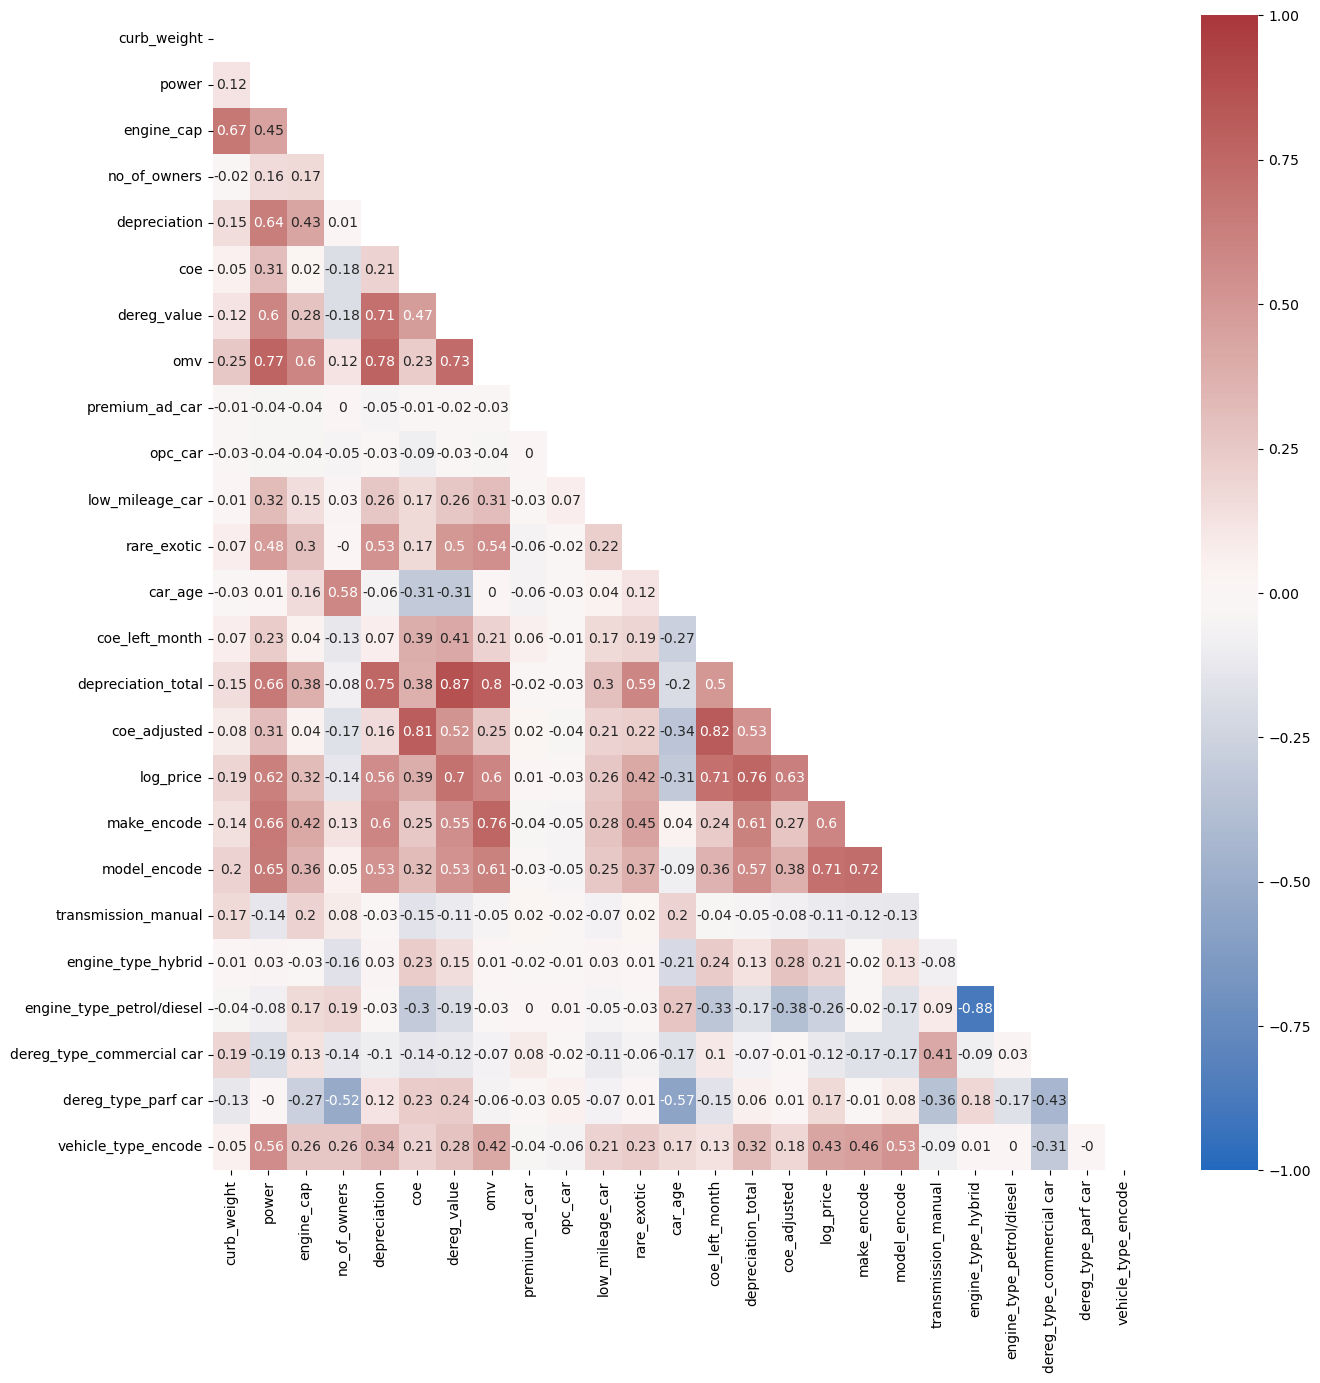

In [50]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

In [51]:
df_cor.head()

curb_weight     power  engine_cap  no_of_owners  depreciation       coe  \
0     0.366229  1.746829    0.890509           2.0      0.693499 -0.042842   
1    -0.136376 -0.002507   -0.017377           2.0      0.031968 -0.089589   
2     0.083139 -0.207601    0.310873           3.0     -0.404845  0.065755   
3    -0.460251 -0.666048   -0.372754           3.0     -0.525031 -0.989825   
4     0.097533  0.576584    0.890509           6.0     -0.345761 -0.021160   

   dereg_value       omv  premium_ad_car  opc_car  ...  coe_adjusted  \
0     0.924762  0.981971               0        0  ...     -0.289888   
1    -0.018437 -0.016289               1        0  ...     -0.354285   
2    -0.491723 -0.278832               1        0  ...     -0.363873   
3    -0.553674 -0.525354               1        0  ...     -0.492083   
4    -0.603086  0.185235               1        0  ...     -0.644717   

   log_price  make_encode  model_encode  transmission_manual  \
0  12.174520    11.916217     12.021958                    0   
1  11.480402    11.608552     11.099386                    0   
2  10.591622    11.034513     10.801187                    0   
3  10.709963    11.185517     10.719189                    0   
4  10.158130    11.427196     11.102980                    0   

   engine_type_hybrid  engine_type_petrol/diesel  dereg_type_commercial car  \
0                   0                          1                          0   
1                   0                          1                          0   
2                   0                          1                          0   
3                   0                          1                          0   
4                   0                          1                          0   

   dereg_type_parf car  vehicle_type_encode  
0                    1            11.437522  
1                    1            11.429823  
2                    0            11.258383  
3                    0            10.794520  
4                    0            11.429823  

[5 rows x 25 columns]

In [52]:
df_cor.to_csv('preprocessed_data_1108.csv',index=False)

In [53]:
df_test = df_test.drop(columns=['make','model','type_of_vehicle','category'])

In [54]:
df_test.to_csv('preprocessed_test_data_1108.csv',index=False)

# Prediction Model

In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


In [56]:
df_train = pd.read_csv('preprocessed_data_1108.csv')
df_test = pd.read_csv('preprocessed_test_data_1108.csv')

In [57]:
df_train.head()

curb_weight     power  engine_cap  no_of_owners  depreciation       coe  \
0     0.366229  1.746829    0.890509           2.0      0.693499 -0.042842   
1    -0.136376 -0.002507   -0.017377           2.0      0.031968 -0.089589   
2     0.083139 -0.207601    0.310873           3.0     -0.404845  0.065755   
3    -0.460251 -0.666048   -0.372754           3.0     -0.525031 -0.989825   
4     0.097533  0.576584    0.890509           6.0     -0.345761 -0.021160   

   dereg_value       omv  premium_ad_car  opc_car  ...  coe_adjusted  \
0     0.924762  0.981971               0        0  ...     -0.289888   
1    -0.018437 -0.016289               1        0  ...     -0.354285   
2    -0.491723 -0.278832               1        0  ...     -0.363873   
3    -0.553674 -0.525354               1        0  ...     -0.492083   
4    -0.603086  0.185235               1        0  ...     -0.644717   

   log_price  make_encode  model_encode  transmission_manual  \
0  12.174520    11.916217     12.021958                    0   
1  11.480402    11.608552     11.099386                    0   
2  10.591622    11.034513     10.801187                    0   
3  10.709963    11.185517     10.719189                    0   
4  10.158130    11.427196     11.102980                    0   

   engine_type_hybrid  engine_type_petrol/diesel  dereg_type_commercial car  \
0                   0                          1                          0   
1                   0                          1                          0   
2                   0                          1                          0   
3                   0                          1                          0   
4                   0                          1                          0   

   dereg_type_parf car  vehicle_type_encode  
0                    1            11.437522  
1                    1            11.429823  
2                    0            11.258383  
3                    0            10.794520  
4                    0            11.429823  

[5 rows x 25 columns]

In [58]:
#df_data = df_data[['power', 'engine_cap', 'depreciation', 'dereg_value', 'omv', 'coe_left_month', 'make_encode', 'model_encode', 'price']]
y = df_train['log_price']
X = df_train.drop(columns=['log_price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
X.head()

curb_weight     power  engine_cap  no_of_owners  depreciation       coe  \
0     0.366229  1.746829    0.890509           2.0      0.693499 -0.042842   
1    -0.136376 -0.002507   -0.017377           2.0      0.031968 -0.089589   
2     0.083139 -0.207601    0.310873           3.0     -0.404845  0.065755   
3    -0.460251 -0.666048   -0.372754           3.0     -0.525031 -0.989825   
4     0.097533  0.576584    0.890509           6.0     -0.345761 -0.021160   

   dereg_value       omv  premium_ad_car  opc_car  ...  depreciation_total  \
0     0.924762  0.981971               0        0  ...            0.200069   
1    -0.018437 -0.016289               1        0  ...           -0.217466   
2    -0.491723 -0.278832               1        0  ...           -0.471614   
3    -0.553674 -0.525354               1        0  ...           -0.421028   
4    -0.603086  0.185235               1        0  ...           -0.589283   

   coe_adjusted  make_encode  model_encode  transmission_manual  \
0     -0.289888    11.916217     12.021958                    0   
1     -0.354285    11.608552     11.099386                    0   
2     -0.363873    11.034513     10.801187                    0   
3     -0.492083    11.185517     10.719189                    0   
4     -0.644717    11.427196     11.102980                    0   

   engine_type_hybrid  engine_type_petrol/diesel  dereg_type_commercial car  \
0                   0                          1                          0   
1                   0                          1                          0   
2                   0                          1                          0   
3                   0                          1                          0   
4                   0                          1                          0   

   dereg_type_parf car  vehicle_type_encode  
0                    1            11.437522  
1                    1            11.429823  
2                    0            11.258383  
3                    0            10.794520  
4                    0            11.429823  

[5 rows x 24 columns]

In [60]:
df_test = df_test.reindex(columns=X.columns)

In [61]:
len(df_test)

10000

In [62]:
from sklearn.linear_model import LinearRegression

# Instantiate and train Linear Regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predict and evaluate
y_pred_linear = linear_regressor.predict(X_test)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_linear = r2_score(y_test, y_pred_linear)

print(f"RMSE of Linear Regression model: {rmse_linear}")
print(f"R^2 of Linear Regression model: {r2_linear}")


RMSE of Linear Regression model: 0.2525496482320663
R^2 of Linear Regression model: 0.9003785245363398


In [63]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Instantiate and train Decision Tree Regressor
tree_regressor = DecisionTreeRegressor(max_depth=None, random_state=42)
tree_regressor.fit(X_train, y_train)

# Predict and evaluate
y_pred_tree = tree_regressor.predict(X_test)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
r2_tree = r2_score(y_test, y_pred_tree)

print(f"RMSE of Decision Tree model: {rmse_tree}")
print(f"R^2 of Decision Tree model: {r2_tree}")


RMSE of Decision Tree model: 0.12249553612731688
R^2 of Decision Tree model: 0.9765631112018719


In [64]:
regressor = RandomForestRegressor(n_estimators=500,
                        max_depth=None,
                        min_samples_split=2,
                        min_samples_leaf=1,
                        max_features=1.0,
                        random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE of the model: {rmse}")
print(f"R^2 of the model: {r2}")

RMSE of the model: 0.09441744523302119
R^2 of the model: 0.9860760029107095


In [65]:
from lightgbm import LGBMRegressor

lgbm_regressor = LGBMRegressor(n_estimators=500, max_depth=6, learning_rate=0.1, random_state=42)
lgbm_regressor.fit(X_train, y_train)

y_pred = lgbm_regressor.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"LightGBM RMSE: {rmse}")
print(f"LightGBM R^2: {r2}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2780
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 24
[LightGBM] [Info] Start training from score 11.297345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [66]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [10, 20, None],
    'num_leaves': [31, 63],
    'learning_rate': [0.05, 0.1],
    'min_child_samples': [20, 50],
    'colsample_bytree': [0.8, 1.0]
}


lgbm = LGBMRegressor(random_state=42)


grid_search = GridSearchCV(estimator=lgbm,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=2,
                           verbose=2,
                           n_jobs=-1)


grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Optimized LightGBM RMSE: {rmse}")
print(f"Optimized LightGBM R^2: {r2}")


Fitting 2 folds for each of 96 candidates, totalling 192 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2735
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 24
[LightGBM] [Info] Start training from score 11.302462
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2735
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 24
[L

In [67]:
import joblib

joblib.dump(best_model, 'best_lightgbm_model.joblib')
print("Model saved as 'best_lightgbm_model.joblib'")


Model saved as 'best_lightgbm_model.joblib'


In [68]:
log_price_predicted = best_model.predict(df_test)
price_predicted = np.exp(log_price_predicted)

results_df = pd.DataFrame({
    'Id': range(len(price_predicted)),  
    'Predicted': price_predicted
})


results_df.to_csv('prediction_1108_lgbm_update.csv', index=False)
print("prediction results have been saved to predictions_lgbm.csv")

prediction results have been saved to predictions_lgbm.csv


In [69]:
import matplotlib.pyplot as plt


feature_importances = best_model.feature_importances_
features = X_train.columns  


importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


                      Feature  Importance
6                 dereg_value        3767
14         depreciation_total        3194
4                depreciation        3052
7                         omv        2275
5                         coe        2185
13             coe_left_month        1997
15               coe_adjusted        1825
0                 curb_weight        1788
2                  engine_cap        1698
1                       power        1687
17               model_encode        1683
12                    car_age        1434
16                make_encode        1021
3                no_of_owners         671
23        vehicle_type_encode         462
22        dereg_type_parf car         395
8              premium_ad_car         281
11                rare_exotic         192
18        transmission_manual         130
10            low_mileage_car         114
20  engine_type_petrol/diesel          53
21  dereg_type_commercial car          48
9                     opc_car     

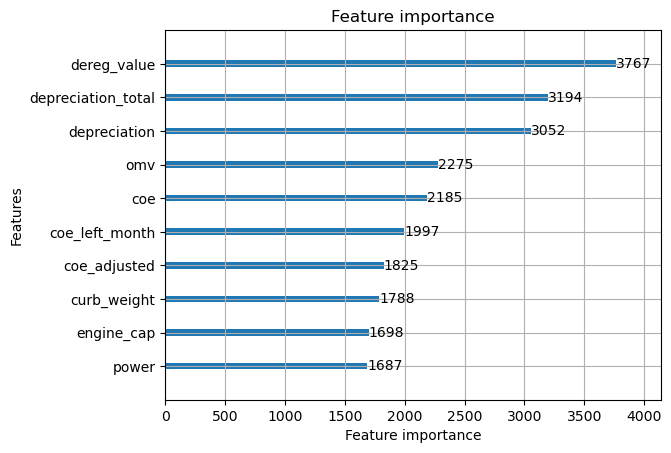

In [70]:
#visualize top 10 feature importance
from lightgbm import plot_importance

plot_importance(best_model, max_num_features=10, importance_type='split')  
plt.show()
